# 0x12 Autoencoders

Recall that autoencoders are neural networks trained to "copy their input to their output". 

They consist of two main parts: 
- an encoder that maps the input to a latent representation, and 
- a decoder that reconstructs the input from this representation.

In this notebook we will explore two kinds of autoencoders:

1. **Denoising Autoencoder (DAE)**: Learns to remove noise from corrupted inputs
2. **Variational Autoencoder (VAE)**: Learns a smooth latent space for generating new samples

We use the MNIST dataset of handwritten digits for our experiments because of its simplicity.

## Setup

First, let's import everything we need and load MNIST.

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

torch.manual_seed(42)
np.random.seed(42)

Using device: cpu


In [2]:
# Load MNIST
transform = transforms.ToTensor()
train_dataset = datasets.MNIST(root="./data", train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root="./data", train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True, num_workers=2, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=True)

print(f"Training samples: {len(train_dataset)}")
print(f"Test samples: {len(test_dataset)}")

Training samples: 60000
Test samples: 10000


# Part 1: Denoising Autoencoder (DAE)

## The Core Idea

A **Denoising Autoencoder** learns to map corrupted inputs back to clean versions: $f_\theta(\tilde{x}) \approx x$

Because it must succeed for many different corruptions $\tilde{x}$, it learns **stable features that ignore noise**.

## Model Architecture

We use a simple convolutional encoder-decoder:
- **Encoder**: Compresses $28 \times 28$ image $\rightarrow$ $7 \times 7 \times 32$ latent representation
- **Decoder**: Reconstructs $7 \times 7 \times 32$ $\rightarrow$ $28 \times 28$ image

We use convolutional layers for downsampling and transposed convolutions for upsampling.

In [ ]:
class DenoisingAutoencoder(nn.Module):
    """Convolutional Denoising Autoencoder"""
    def __init__(self):
        super().__init__()
        # Encoder: 28x28 → 14x14 → 7x7
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, 3, stride=2, padding=1),  # → 14x14x16
            nn.ReLU(),
            nn.Conv2d(16, 32, 3, stride=2, padding=1), # → 7x7x32
            nn.ReLU(),
        )
        # Decoder: 7x7 → 14x14 → 28x28
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(32, 16, 4, stride=2, padding=1), # → 14x14x16
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, 4, stride=2, padding=1),  # → 28x28x1
            nn.Sigmoid()  # Output in [0, 1]
        )

    def forward(self, x):
        z = self.encoder(x)
        x_recon = self.decoder(z)
        return x_recon

dae = DenoisingAutoencoder().to(device)
print(dae)
print(f"\nTotal parameters: {sum(p.numel() for p in dae.parameters()):,}")

DenoisingAutoencoder(
  (encoder): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (3): ReLU()
  )
  (decoder): Sequential(
    (0): ConvTranspose2d(32, 16, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
    (2): ConvTranspose2d(16, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (3): Sigmoid()
  )
)

Total parameters: 13,265


## Noise Corruption Function

We add Gaussian noise to the clean images during training.

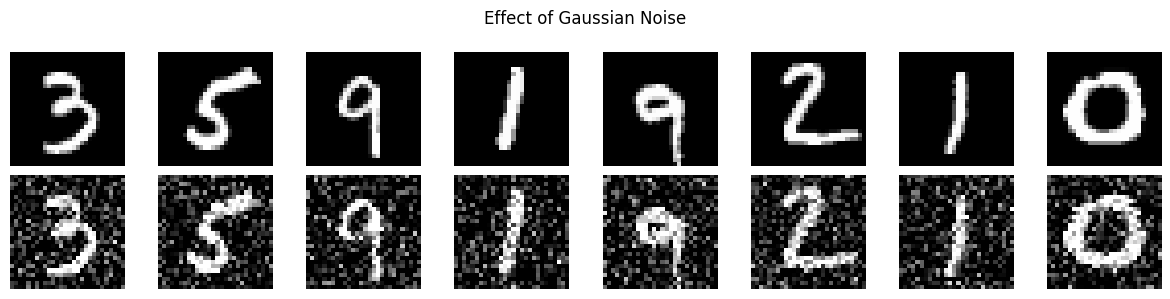

In [4]:
def add_noise(x, sigma):
    """Add Gaussian noise to images and clamp to [0, 1]."""
    return (x + sigma * torch.randn_like(x)).clamp(0, 1)

# Visualize noise effect
x_batch, _ = next(iter(test_loader))
x_noisy = add_noise(x_batch, sigma=0.3)

fig, axes = plt.subplots(2, 8, figsize=(12, 3))
for i in range(8):
    axes[0, i].imshow(x_batch[i, 0], cmap='gray')
    axes[0, i].axis('off')
    axes[1, i].imshow(x_noisy[i, 0], cmap='gray')
    axes[1, i].axis('off')
axes[0, 0].set_ylabel('Clean', fontsize=12)
axes[1, 0].set_ylabel('Noisy ($\\sigma=0.3$)', fontsize=12)
plt.suptitle('Effect of Gaussian Noise')
plt.tight_layout()
plt.show()

## Visualization Helper

This function shows clean/noisy/reconstructed triplets side-by-side.

In [5]:
@torch.no_grad()
def visualize_denoising(model, loader, sigma=0.3, title=""):
    """Show clean, noisy, and reconstructed images."""
    model.eval()
    x_clean, _ = next(iter(loader))
    x_clean = x_clean.to(device)
    x_noisy = add_noise(x_clean, sigma)
    x_recon = model(x_noisy)

    n = 8
    fig, axes = plt.subplots(3, n, figsize=(1.5*n, 4.5))
    for i in range(n):
        axes[0, i].imshow(x_clean[i, 0].cpu(), cmap='gray')
        axes[0, i].axis('off')
        axes[1, i].imshow(x_noisy[i, 0].cpu(), cmap='gray')
        axes[1, i].axis('off')
        axes[2, i].imshow(x_recon[i, 0].cpu(), cmap='gray')
        axes[2, i].axis('off')

    axes[0, 0].set_ylabel('Clean', fontsize=12)
    axes[1, 0].set_ylabel('Noisy', fontsize=12)
    axes[2, 0].set_ylabel('Reconstructed', fontsize=12)
    plt.suptitle(title, fontsize=14)
    plt.tight_layout()
    plt.show()

### Before Training

Let's see what happens with an untrained model (should look terrible - that's good!).

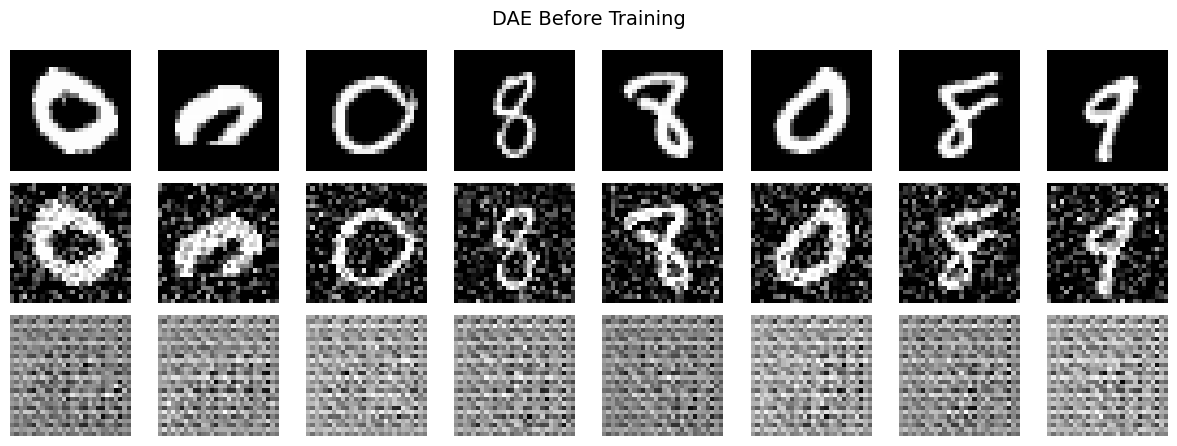

In [6]:
visualize_denoising(dae, test_loader, sigma=0.3, title="DAE Before Training")

## Training the DAE

We train for a small number of steps (2-4 minutes on CPU, faster on GPU).

**Key insight**: We corrupt the input but use the *clean* image as the target!

In [7]:
optimizer_dae = torch.optim.Adam(dae.parameters(), lr=1e-3)
noise_sigma = 0.3
num_steps = 600  # Adjust: 300 if slow, 1000 if fast

print("Training Denoising Autoencoder...")
print("We're explicitly training the network to ignore noise.")
print("If it generalizes, it should denoise unseen digits too.\n")

dae.train()
train_iter = iter(train_loader)
losses = []

for step in range(1, num_steps + 1):
    try:
        x_clean, _ = next(train_iter)
    except StopIteration:
        train_iter = iter(train_loader)
        x_clean, _ = next(train_iter)

    x_clean = x_clean.to(device)
    x_noisy = add_noise(x_clean, sigma=noise_sigma)

    # Forward pass
    x_recon = dae(x_noisy)
    loss = F.mse_loss(x_recon, x_clean)

    # Backward pass
    optimizer_dae.zero_grad()
    loss.backward()
    optimizer_dae.step()

    losses.append(loss.item())

    if step % 200 == 0:
        print(f"Step {step}/{num_steps} | Loss: {loss.item():.4f}")

print("\nTraining complete!")

Training Denoising Autoencoder...
We're explicitly training the network to ignore noise.
If it generalizes, it should denoise unseen digits too.

Step 200/600 | Loss: 0.1015
Step 400/600 | Loss: 0.0110
Step 600/600 | Loss: 0.0071

Training complete!


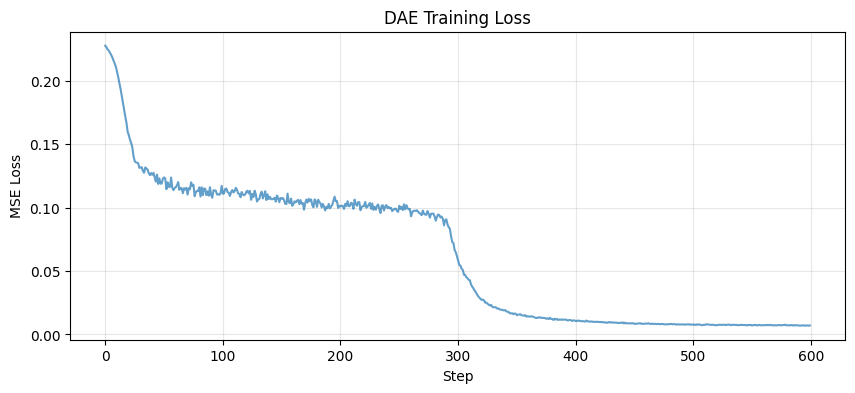

In [8]:
# Plot training loss
plt.figure(figsize=(10, 4))
plt.plot(losses, alpha=0.7)
plt.xlabel('Step')
plt.ylabel('MSE Loss')
plt.title('DAE Training Loss')
plt.grid(True, alpha=0.3)
plt.show()

### After Training

Now the model should remove noise effectively!

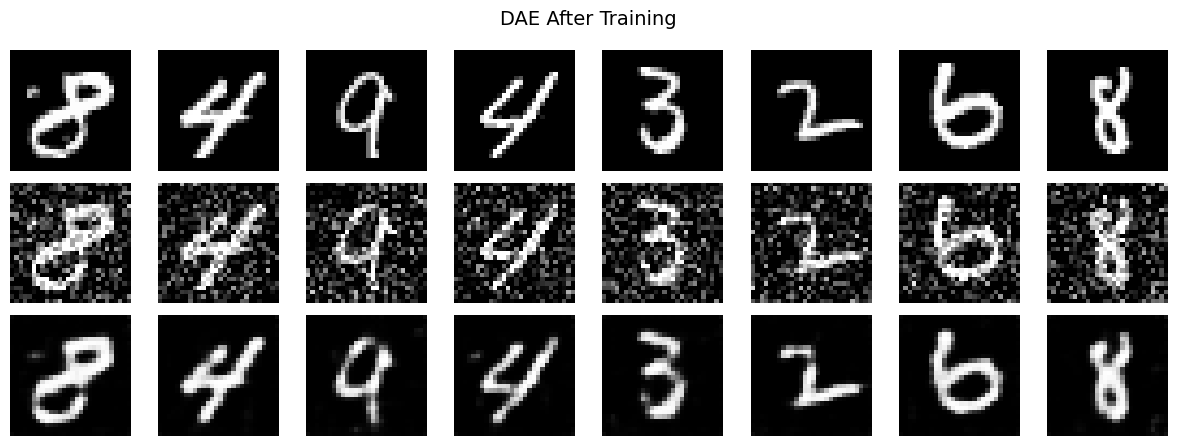

In [9]:
visualize_denoising(dae, test_loader, sigma=0.3, title="DAE After Training")

> 🤔 **THINKING**
> - What features must the encoder learn to successfully denoise?

### Testing Generalization

Does DAE work with *different* noise levels than it was trained on?

Testing on different noise levels:
(Trained on $\sigma=0.3$)



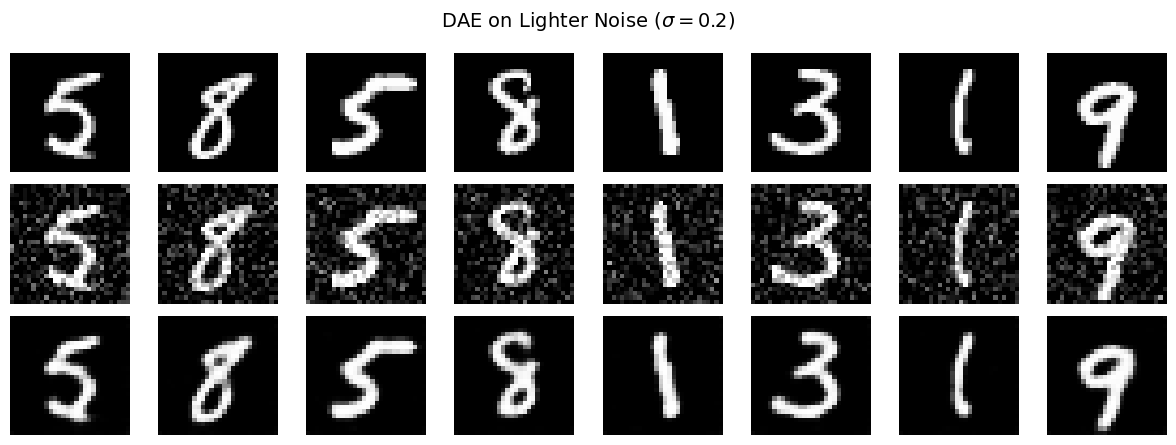

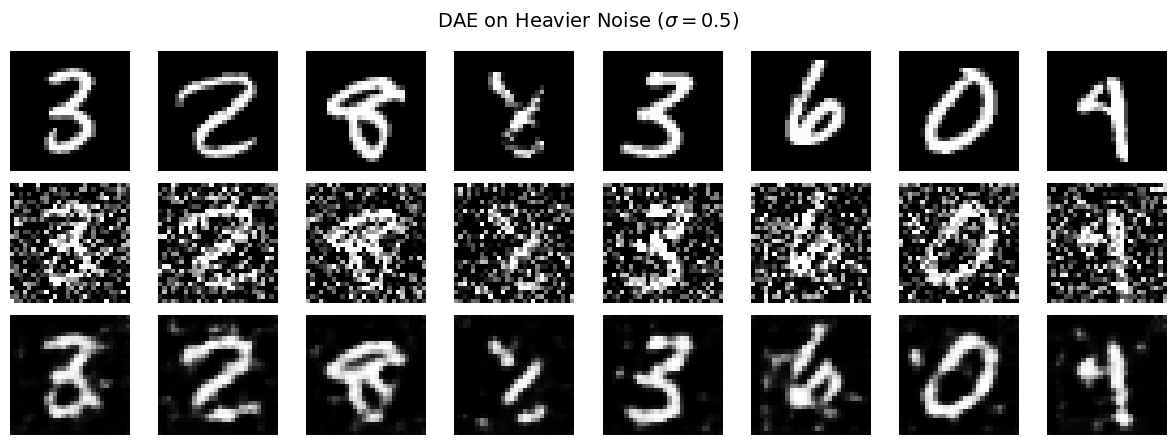

In [10]:
print("Testing on different noise levels:")
print("(Trained on $\\sigma=0.3$)\n")

visualize_denoising(dae, test_loader, sigma=0.2, title="DAE on Lighter Noise ($\\sigma=0.2$)")
visualize_denoising(dae, test_loader, sigma=0.5, title="DAE on Heavier Noise ($\\sigma=0.5$)")

# Part 2: Variational Autoencoder (VAE)

A **Variational Autoencoder** learns a **smooth, structured latent space** where:
1. Similar inputs map to nearby latent points
2. Random samples from the latent space decode to valid outputs
3. Interpolation between latent points produces smooth transitions

We will go through the following experiments to iilustrate:
- **Sampling**: Generate new digits from random latent codes $z \sim \mathcal{N}(0, I)$
- **Interpolation**: Smooth morphing between different digits

## VAE Architecture

A VAE has three key components:

1. **Encoder**: Maps input $x$ to latent distribution parameters $(\mu, \sigma^2)$
2. **Reparameterization**: Samples $z = \mu + \sigma \odot \epsilon$ where $\epsilon \sim \mathcal{N}(0, I)$
3. **Decoder**: Reconstructs $x$ from $z$

We use a simple MLP architecture this time.

In [11]:
latent_dim = 8

class VAE(nn.Module):
    """Variational Autoencoder with MLP architecture"""
    def __init__(self, latent_dim=8):
        super().__init__()
        self.latent_dim = latent_dim

        # Encoder
        self.fc1 = nn.Linear(28*28, 256)
        self.fc_mu = nn.Linear(256, latent_dim)
        self.fc_logvar = nn.Linear(256, latent_dim)

        # Decoder
        self.fc2 = nn.Linear(latent_dim, 256)
        self.fc3 = nn.Linear(256, 28*28)

    def encode(self, x):
        """Encode input to latent distribution parameters."""
        h = F.relu(self.fc1(x))
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        """Sample z from N(mu, sigma^2) using reparameterization trick."""
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        z = mu + eps * std
        return z

    def decode(self, z):
        """Decode latent code to reconstruction."""
        h = F.relu(self.fc2(z))
        x_recon = torch.sigmoid(self.fc3(h))
        return x_recon

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        x_recon = self.decode(z)
        return x_recon, mu, logvar

vae = VAE(latent_dim).to(device)
print(vae)
print(f"\nLatent dimension: {latent_dim}")
print(f"Total parameters: {sum(p.numel() for p in vae.parameters()):,}")

VAE(
  (fc1): Linear(in_features=784, out_features=256, bias=True)
  (fc_mu): Linear(in_features=256, out_features=8, bias=True)
  (fc_logvar): Linear(in_features=256, out_features=8, bias=True)
  (fc2): Linear(in_features=8, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=784, bias=True)
)

Latent dimension: 8
Total parameters: 408,864


> 🤔 **THINKING**
> - Don't we model the variance $\sigma^2$? Why does the neural network output $\log\sigma^2$ instead? (Hint: What is the range of possible values for $\sigma^2$ vs. $\log\sigma^2$?)

## VAE Loss Function

The VAE loss has two components:

$$\mathcal{L} = \mathcal{L}_{\text{recon}} + \beta \cdot \mathcal{L}_{\text{KL}}$$

1. **Reconstruction loss**: How well can we reconstruct the input?
2. **KL divergence**: How close is the latent distribution to $\mathcal{N}(0, I)$?

The $\beta$ parameter controls the tradeoff:
- Small $\beta$ → sharper reconstructions, less structured latent space
- Large $\beta$ → smoother latent space, blurrier reconstructions

In [12]:
def vae_loss(x_recon, x, mu, logvar, beta=1.0):
    """Compute VAE loss = reconstruction + beta * KL divergence."""
    batch_size = x.size(0)

    # Reconstruction loss (binary cross-entropy)
    recon_loss = F.binary_cross_entropy(x_recon, x, reduction='sum') / batch_size

    # KL divergence: KL(N(mu, sigma^2) || N(0, 1))
    # = 0.5 * sum(exp(logvar) + mu^2 - 1 - logvar)
    kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp()) / batch_size

    total_loss = recon_loss + beta * kl_loss

    return total_loss, recon_loss, kl_loss

## Visualization Helpers for VAE

In [13]:
@torch.no_grad()
def sample_digits(model, n=16):
    """Generate new digits by sampling z ~ N(0, I)."""
    model.eval()
    z = torch.randn(n, model.latent_dim).to(device)
    x_samples = model.decode(z).view(n, 1, 28, 28).cpu()

    fig, axes = plt.subplots(4, 4, figsize=(6, 6))
    for i, ax in enumerate(axes.flat):
        ax.imshow(x_samples[i, 0], cmap='gray')
        ax.axis('off')
    plt.suptitle('VAE Samples ($z \\sim \\mathcal{N}(0, I)$)', fontsize=14)
    plt.tight_layout()
    plt.show()

@torch.no_grad()
def interpolate_latent(model, x1, x2, steps=10):
    """Interpolate between two images in latent space."""
    model.eval()
    x1 = x1.view(1, -1).to(device)
    x2 = x2.view(1, -1).to(device)

    # Encode to latent space (use mean for cleaner interpolation)
    mu1, _ = model.encode(x1)
    mu2, _ = model.encode(x2)

    # Linear interpolation in latent space
    alphas = torch.linspace(0, 1, steps)
    latents = [(1 - alpha) * mu1 + alpha * mu2 for alpha in alphas]

    # Decode interpolated latents
    images = [model.decode(z).view(28, 28).cpu() for z in latents]

    fig, axes = plt.subplots(1, steps, figsize=(1.5*steps, 2))
    for i, ax in enumerate(axes):
        ax.imshow(images[i], cmap='gray')
        ax.axis('off')
    plt.suptitle('Latent Space Interpolation ($\\mu_1 \\rightarrow \\mu_2$)', fontsize=14)
    plt.tight_layout()
    plt.show()

@torch.no_grad()
def visualize_reconstruction(model, loader, n=8):
    """Show original vs reconstructed images."""
    model.eval()
    x, _ = next(iter(loader))
    x = x.to(device)
    x_flat = x.view(x.size(0), -1)
    x_recon, _, _ = model(x_flat)
    x_recon = x_recon.view(-1, 1, 28, 28)

    fig, axes = plt.subplots(2, n, figsize=(1.5*n, 3))
    for i in range(n):
        axes[0, i].imshow(x[i, 0].cpu(), cmap='gray')
        axes[0, i].axis('off')
        axes[1, i].imshow(x_recon[i, 0].cpu(), cmap='gray')
        axes[1, i].axis('off')
    axes[0, 0].set_ylabel('Original', fontsize=12)
    axes[1, 0].set_ylabel('Reconstructed', fontsize=12)
    plt.suptitle('VAE Reconstruction', fontsize=14)
    plt.tight_layout()
    plt.show()

## Training the VAE

In [14]:
optimizer_vae = torch.optim.Adam(vae.parameters(), lr=1e-3)
beta = 1.0
num_steps = 800

print(f"Training VAE with $\\beta={beta}$...")
print("The KL term forces latent codes toward $\\mathcal{N}(0, I)$, making random sampling work!\n")

vae.train()
train_iter = iter(train_loader)
total_losses = []
recon_losses = []
kl_losses = []

for step in range(1, num_steps + 1):
    try:
        x, _ = next(train_iter)
    except StopIteration:
        train_iter = iter(train_loader)
        x, _ = next(train_iter)

    x = x.view(x.size(0), -1).to(device)

    # Forward pass
    x_recon, mu, logvar = vae(x)
    loss, recon, kl = vae_loss(x_recon, x, mu, logvar, beta=beta)

    # Backward pass
    optimizer_vae.zero_grad()
    loss.backward()
    optimizer_vae.step()

    total_losses.append(loss.item())
    recon_losses.append(recon.item())
    kl_losses.append(kl.item())

    if step % 200 == 0:
        print(f"Step {step}/{num_steps} | Total: {loss.item():.2f} | Recon: {recon.item():.2f} | KL: {kl.item():.2f}")

print("\nTraining complete!")

Training VAE with $\beta=1.0$...
The KL term forces latent codes toward $\mathcal{N}(0, I)$, making random sampling work!

Step 200/800 | Total: 153.67 | Recon: 140.00 | KL: 13.67
Step 400/800 | Total: 136.36 | Recon: 122.07 | KL: 14.29
Step 600/800 | Total: 133.12 | Recon: 118.65 | KL: 14.47
Step 800/800 | Total: 129.87 | Recon: 115.43 | KL: 14.44

Training complete!


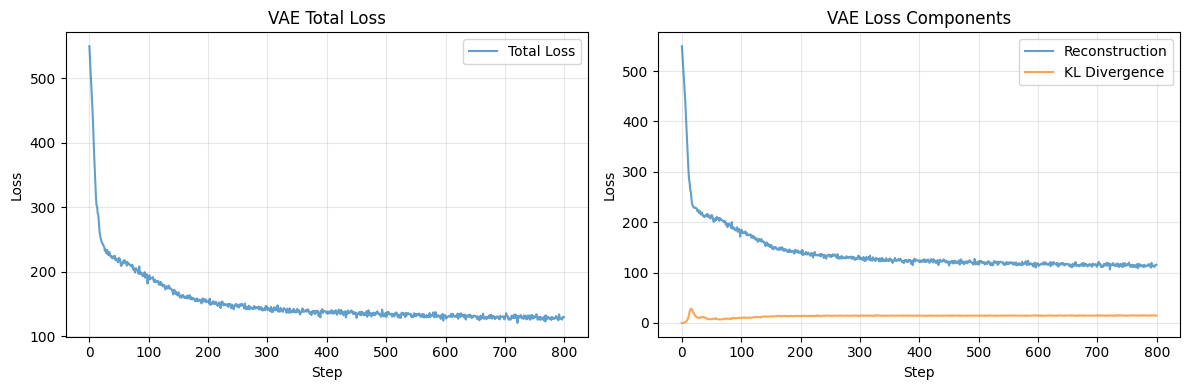

In [15]:
# Plot training losses
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(total_losses, alpha=0.7, label='Total Loss')
plt.xlabel('Step')
plt.ylabel('Loss')
plt.title('VAE Total Loss')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.plot(recon_losses, alpha=0.7, label='Reconstruction')
plt.plot(kl_losses, alpha=0.7, label='KL Divergence')
plt.xlabel('Step')
plt.ylabel('Loss')
plt.title('VAE Loss Components')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## VAE Results

Now comes the exciting part - let's see what the VAE learned!

### 1. Reconstruction Quality

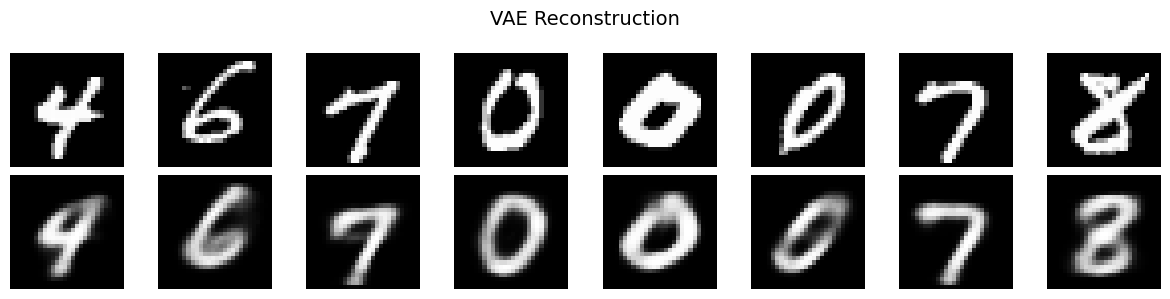

In [16]:
visualize_reconstruction(vae, test_loader)

### 2. Generating New Digits

**This is the key difference from a regular autoencoder**: we can sample random $z \sim \mathcal{N}(0, I)$ and decode to get valid digits!

The KL regularization ensures the latent space is "fillable" - every point maps to something reasonable.

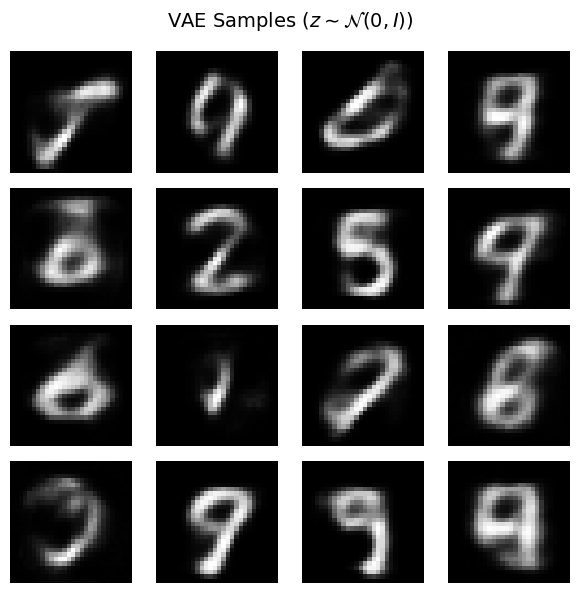

In [17]:
sample_digits(vae, n=16)

### 3. Latent Space Interpolation

One of the most beautiful properties of VAEs: smooth interpolation between different digits.

Interpolating between two random test digits...



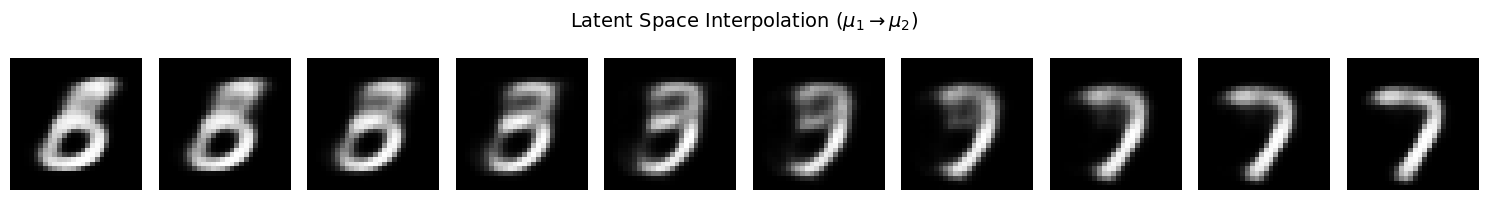

In [18]:
x_batch, _ = next(iter(test_loader))
print("Interpolating between two random test digits...\n")
interpolate_latent(vae, x_batch[0], x_batch[1], steps=10)

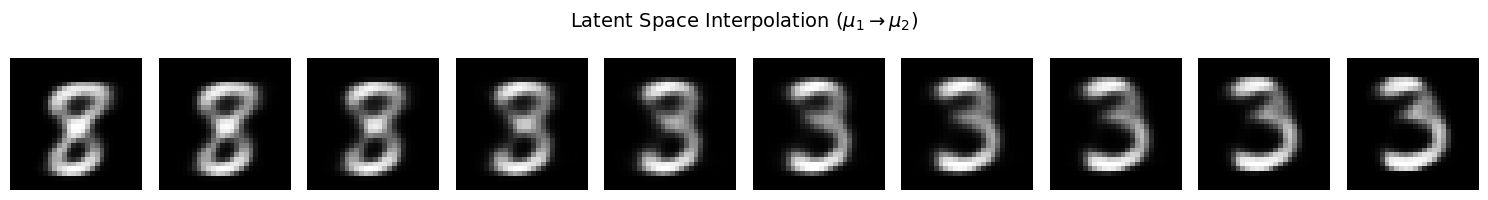

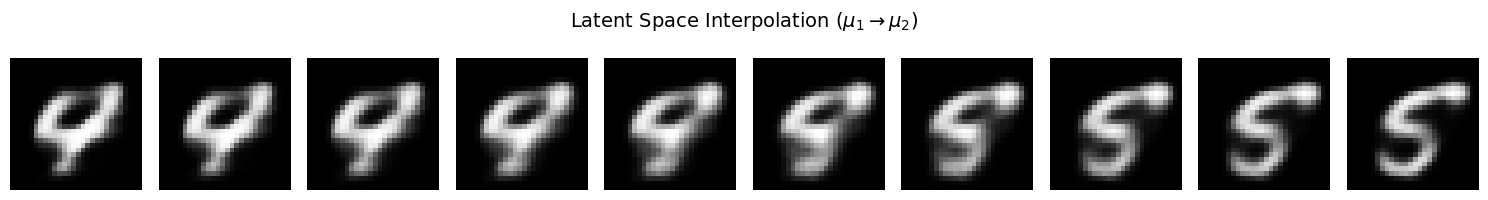

In [19]:
# Try more interpolations
interpolate_latent(vae, x_batch[2], x_batch[3], steps=10)
interpolate_latent(vae, x_batch[4], x_batch[5], steps=10)

> 🤔 **THINKING**
>
> - Why does the interpolation look smooth? What does this tell you about the latent space?
> - What happens in the middle of the interpolation?
> - A regular autoencoder doesn't have the KL term. Why would its interpolations be worse?

## The β Parameter: Quality vs Structure Tradeoff

The $\beta$ parameter controls how much we prioritize the KL regularization:

- **Small β (e.g., 0.1)**: Sharper reconstructions, but latent space may have "holes"
- **Large β (e.g., 4.0)**: Smoother latent space, but blurrier reconstructions

This is sometimes called **β-VAE**.

> 📚 **EXERCISE**
>
> 1. **2D Latent Space**: Train a VAE with `latent_dim=2` and create a 2D visualization of the latent space. Plot where each digit class clusters. Use `plt.scatter` with colors for different digits.
>
> 2. **Latent Space Arithmetic**: Encode several images of the same digit, compute the average latent vector, then decode it. Does it look like a "prototype" of that digit?
>
> 3. **Compare with Regular AE**: Implement a regular autoencoder (no KL loss, just reconstruction). Compare:
>    - Reconstruction quality
>    - What happens when you sample random z and decode
>    - Interpolation smoothness

In [20]:
# === Your code here ===